In [6]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pprint import pprint
from scipy import stats
from sklearn import preprocessing
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from pandas_profiling import ProfileReport
import math

In [7]:
%matplotlib inline

In [8]:
TRAIN_PATH = "/workspace/data/predict_future_sales/sales_train.csv"

train_df = pd.read_csv(TRAIN_PATH)
train_df['item_sum'] = train_df['item_price'] * train_df['item_cnt_day']

train_df['date'] = train_df['date'].apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
train_df['month'] = train_df['date'].apply(lambda x: x.strftime("%Y%m"))

In [9]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_sum,month
0,2013-01-02,0,59,22154,999.00,1.0,999.00,201301
1,2013-01-03,0,25,2552,899.00,1.0,899.00,201301
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,201301
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,201301
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,201301


# モデル使用データ

In [10]:
#元データ
ts=train_df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

# トレンド除去
ts_diff = ts.diff().dropna()

# 季節性除去
ts_diff_12 = ts.diff(12).dropna()

# SARIMAXモデルを構築

モデル　＝　短期の自己相関（ARMA) + 季節性分（S）+ トレンド（差分で消す）<br>
とする　※外因性は考えない

## memo

元データのARIMA(1,0,0）＝ I(1)のARIMA(1,0,0)<br>
元データのARIMA(0,1,1) = I(1)のARIMA(0,0,1)<br>
元データのARIMA(0,1,2) = I(1)のARIMA(0,0,2)<br>
元データのSARIMA(0,0,0)(1,1,0,12）＝ I(12)のSARIMA(0,0,0)(1,0,0,12)<br>

元データのARIMA(1,12,0) ≠ I(12)のARIMA(1,0,0)<br>
元データのARIMA(1,2,0) ≠ I(2)のARIMA(1,0,0)<br>
元データのARIMA(1,0,1) ≠ I(1)のARIMA(1,0,1)<br>

上記より、
 - ARモデル/MAモデルのみを使い、かつ1次和分過程だった場合は、元データのARIMAと一致
 - 2回以上の差分やARMAモデルにすると不一致

In [11]:
# 12月のみフラグ付け
dec_df = train_df.copy()
dec_df = dec_df.sort_values("date_block_num")
dec_df = dec_df.drop_duplicates("date_block_num")['Dec_flg']
dec_df = dec_df.reset_index(drop=True)


KeyError: 'Dec_flg'

## 最適な次数を見つける

In [117]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_sp = 1
max_sq = 1

pattern = max_p*(max_q + 1)*(max_sp + 1)*(max_sq + 1)
modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# # 自動SARIMA選択
# num = 0
# for p in range(1, max_p + 1):
#     for q in range(0, max_q + 1):
#         for sp in range(0, max_sp + 1):
#             for sq in range(0, max_sq + 1):
#                 sarima = sm.tsa.SARIMAX(
#                     ts, order=(p,1,q), 
#                     seasonal_order=(sp,1,sq,12), 
#                     enforce_stationarity = False, 
#                     enforce_invertibility = False,
#                 ).fit()
#                 modelSelection.iloc[num]["model"] = f"order=({p},1,{q}), season=({sp},1,{sq})"
#                 modelSelection.iloc[num]["aic"] = sarima.aic
#                 num = num + 1

# 自動SARIMA選択
num = 0
for p in range(1, max_p + 1):
    for q in range(0, max_q + 1):
        sarima = sm.tsa.SARIMAX(
            # ts_diff_12.reset_index(drop=True),
            ts,
            order=(p,12,q), 
            enforce_stationarity = False, 
            enforce_invertibility = False,
            
        ).fit(disp=False)
        modelSelection.iloc[num]["model"] = f"order=({p},12,{q}))"
        modelSelection.iloc[num]["aic"] = sarima.aic
        num = num + 1

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [118]:
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
11,"order=(3,12,3))",592.412061


## モデル構築

In [143]:
# sarima = sm.tsa.SARIMAX(ts,
#                         order=(1,1,3), seasonal_order=(0,1,0,12),
#                         enforce_stationarity = False, enforce_invertibility = False).fit()
sarima = sm.tsa.SARIMAX(ts,
                        order=(0,0,0),seasonal_order=(1,1,0,2), 
                        enforce_stationarity = False, enforce_invertibility = False).fit(disp=False)
sarima.aic

701.2852290566282

In [107]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   34
Model:              SARIMAX(2, 12, 3)   Log Likelihood                -262.201
Date:                Thu, 10 Feb 2022   AIC                            538.403
Time:                        09:42:26   BIC                            544.635
Sample:                             0   HQIC                           539.262
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.593e+04   2.76e+04      1.666      0.096   -8100.414       1e+05
ar.L1         -1.4146      1.267     -1.116      0.264      -3.898       1.069
ar.L2         -0.8533      1.170     -0.729      0.466      -3.146       1.440
ma.L1         -2.6198      0.963     -2.720      0.007      -4.507      -0.732
ma.L2          2.5458      2.014      1.264      0.206      -1.401       6.492
ma.L3         -0.9103      1.318     -0.691      0.490      -3.493       1.673
sigma2      6.137e+11   8.39e-05   7.31e+15      0.000    6.14e+11    6.14e+11
===================================================================================
Ljung-Box (L1) (Q):                   5.04   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.02   Prob(JB):                         0.41
Heteroskedasticity (H):               0.67   Skew:                            -0.77
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+33. Standard errors may be unstable.
"""

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'rawdata SARIMA pacf')

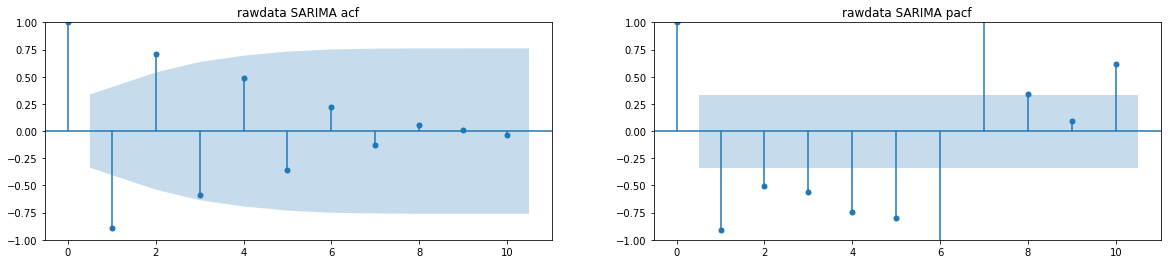

In [105]:
# 残差のチェック
residSARIMA = sarima.resid
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=10, ax=ax1)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=10, ax=ax2)

ax1.set_title("rawdata SARIMA acf")
ax2.set_title("rawdata SARIMA pacf")

## 残差がうまく取り除けていないので、元データと見比べ

Text(0.5, 1.0, 'SARIMA resid data')

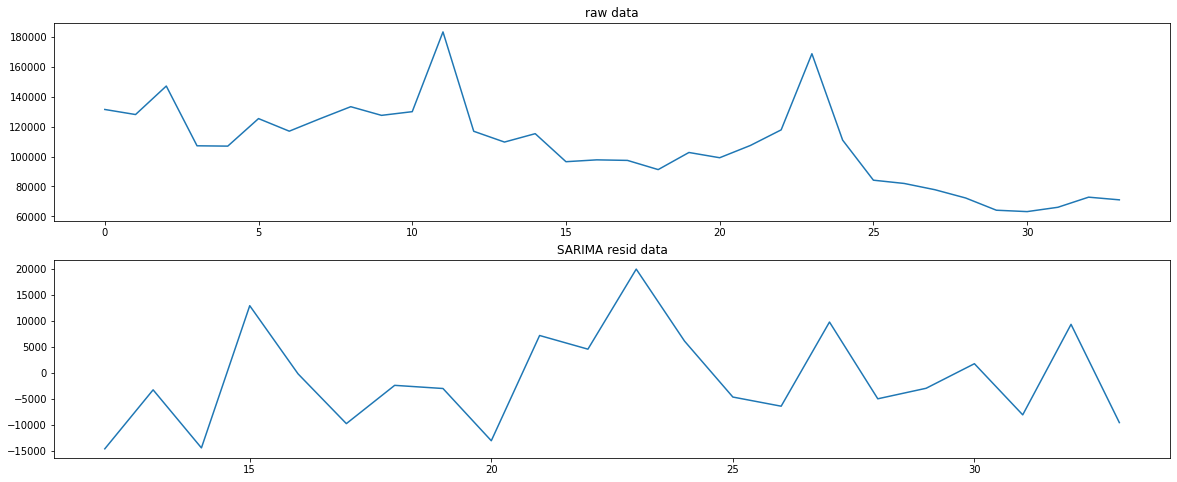

In [97]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots(2,1)

ax[0].plot(ts.index, ts.values)
ax[1].plot(residSARIMA.index, residSARIMA.values)

ax[0].set_title("raw data")
ax[1].set_title("SARIMA resid data")

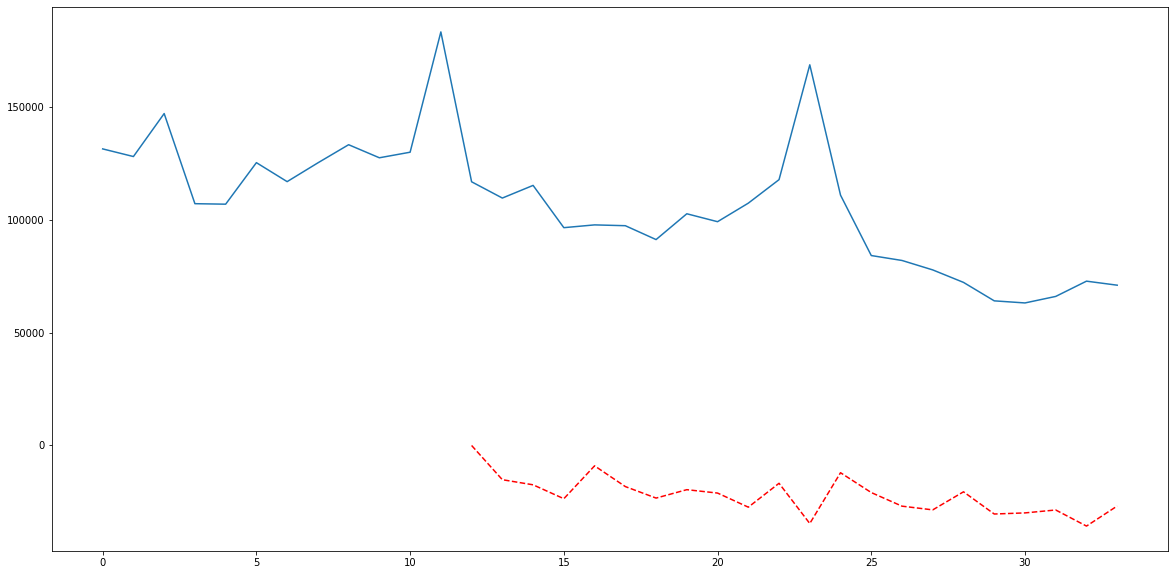

In [98]:
# 予測
bestPred = sarima.predict()
# 実データと予測結果の図示
plt.figure(figsize=(20,10))
plt.plot(ts)
plt.plot(bestPred, "r", linestyle='--')

#### 調査：月によって販売店舗数に差があるか

残差はほとんど定常過程っぽいが、1時点だけ異常値をだしている（13地点）<br>
原因として、店舗数が急に拡大したか確認<br>

<span>結論：関係なし</span>

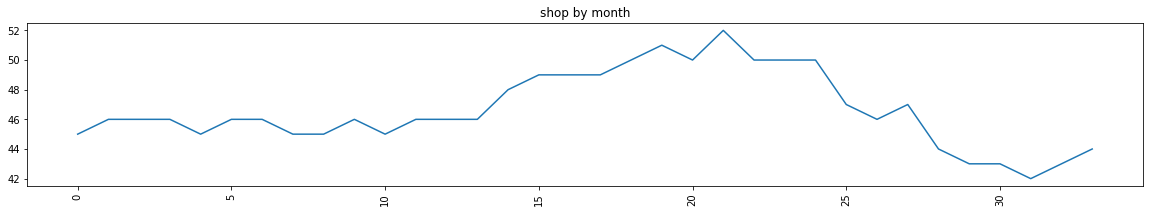

In [33]:
test = train_df.groupby("date_block_num")['shop_id'].nunique()
plt.figure(figsize=(20,3))
plt.plot(test.index, test.values)
plt.title("shop by month")
plt.xticks(rotation=90)
plt.show()

## ARIMAのパラメータ推定

すでに1次和分過程で単位根であることはわかっているので、ARMAのパラメータを見つける<br>
ARMA(1,1)より、<span style="color:red;">ARIMA(1,1,1）</span>とパラメータが決まった。

In [13]:
# 差分系列への自動ARMA推定関数の実行
resDiff = sm.tsa.arma_order_select_ic(ts_diff, ic='aic', trend='n')
resDiff

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'aic':             0           1           2
 0  758.457601  756.327954  757.920056
 1  757.823538  757.435784  759.823583
 2  757.560918  759.474486  761.813851
 3  759.488504  761.474049  762.977830
 4  761.365953  762.186626  761.913615,
 'aic_min_order': (0, 1)}

### SARIMAのパラメータ推定

In [15]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_sp = 1
max_sd = 1
pattern = (max_sp + 1)*(max_sd + 1)
modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0
for sp in range(0, max_sp+1):
    for sq in range(0, max_sd+1):
        sarima = sm.tsa.SARIMAX(
            ts_diff, order=(0,1,1), 
            seasonal_order=(sp,1,sq,12), 
            enforce_stationarity = False, 
            enforce_invertibility = False
        ).fit()
        modelSelection.iloc[num]["model"] = f"order=(1,1,1), season=({sp},1,{sq})"
        modelSelection.iloc[num]["aic"] = sarima.aic
        num = num + 1

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88095D+00    |proj g|=  1.66920D-01

At iterate    5    f=  5.83964D+00    |proj g|=  2.02506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   1.798D-05   5.840D+00
  F =   5.8396416749325937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


In [16]:
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
1,"order=(1,1,1), season=(0,1,1)",133.798724


### モデル構築

In [17]:
sarima = sm.tsa.SARIMAX(ts_diff, 
                        order=(1,1,1), seasonal_order=(0,1,1,12), 
                        enforce_stationarity = False, enforce_invertibility = False).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92584D+00    |proj g|=  4.98797D-02

At iterate    5    f=  1.90864D+00    |proj g|=  2.68866D-02

At iterate   10    f=  1.90604D+00    |proj g|=  2.03079D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     18      1     0     0   1.193D-05   1.906D+00
  F =   1.9060412794029411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


In [18]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       item_cnt_day   No. Observations:                   33
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -62.899
Date:                            Wed, 09 Feb 2022   AIC                            133.799
Time:                                    08:20:39   BIC                            132.966
Sample:                                         0   HQIC                           130.464
                                             - 33                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0246      4.127     -0.248      0.804      -9.113       7.063
ma.L1         -0.9311      6.341     -0.147      0.883     -13.360      11.497
ma.S.L12       0.2738      1.747      0.157      0.875      -3.151       3.699
sigma2      1.794e+08   1.61e-08   1.11e+16      0.000    1.79e+08    1.79e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.21   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.14   Prob(JB):                         0.84
Heteroskedasticity (H):               1.02   Skew:                            -0.28
Prob(H) (two-sided):                  0.99   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.18e+35. Standard errors may be unstable.
"""

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


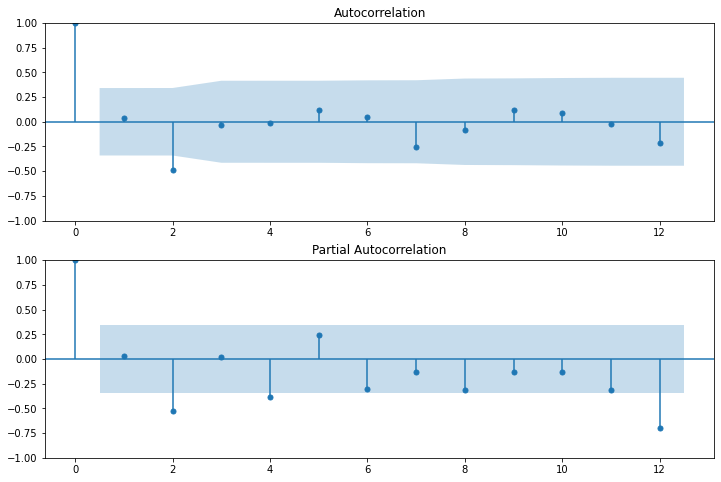

In [19]:
# 残差のチェック
residSARIMA = sarima.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=12, ax=ax2)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


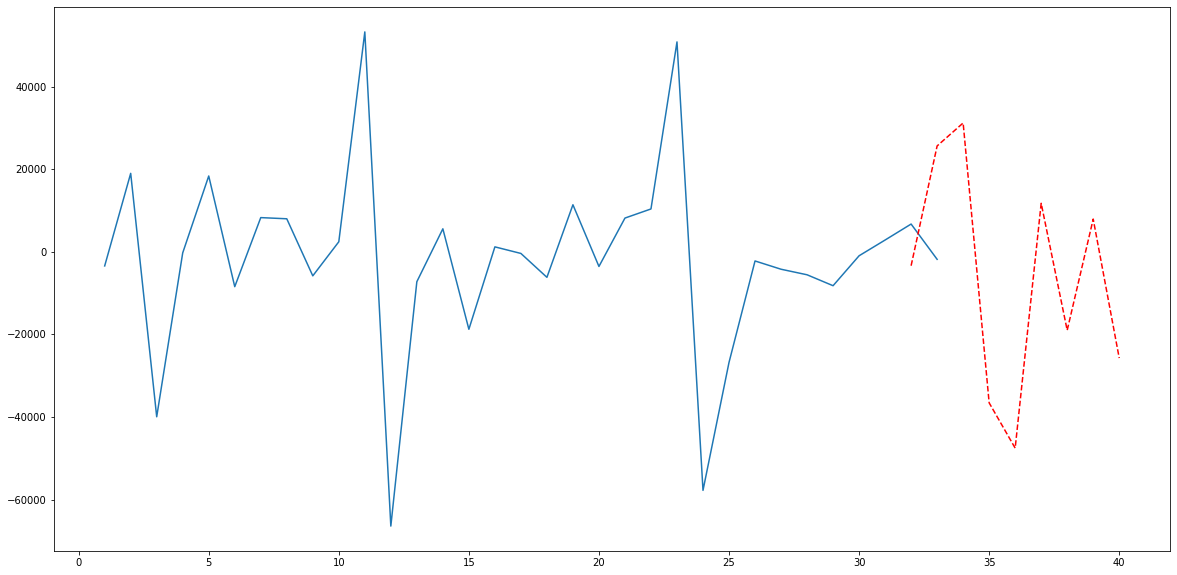

In [23]:
# 予測
bestPred = sarima.predict(32, 40)
# 実データと予測結果の図示
plt.figure(figsize=(20,10))
plt.plot(ts_diff)
plt.plot(bestPred, "r", linestyle='--')

## logデータへのSARIMA適応 （SARIMAパラメータの総探し）

In [181]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts_log, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.iloc[num]["model"] = f"order=({p},{d},{q}), season=({sp},{sd},{sq}))"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40433D-01    |proj g|=  2.23516D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   2.235D-02  -3.404D-01
  F = -0.34043316738634033     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.8

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/s


At iterate   10    f= -1.95903D-01    |proj g|=  1.58596D-01

At iterate   15    f= -1.97377D-01    |proj g|=  4.19483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   3.208D-04  -1.974D-01
  F = -0.19737740589136352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.20346D-01    |proj g|=  2.39111D+00

At iterate    5    f= -5.76292D-01    |proj g|=  8.64134D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   25    f= -6.05901D-01    |proj g|=  1.39791D-02

At iterate   30    f= -6.05909D-01    |proj g|=  6.81033D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     41      1     0     0   7.875D-05  -6.059D-01
  F = -0.60590930724226066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08004D-02    |proj g|=  4.83365D+00

At iterate    5    f= -1.23057D-01    |proj g|=  9.98161D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     81      2     0     0   2.495D-03  -2.649D-01
  F = -0.26487439435881666     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82706D-01    |proj g|=  9.86750D-01

At iterate    5    f= -1.91802D-01    |proj g|=  5.33120D-02

At iterate   10    f= -1.95952D-01    |proj g|=  1.60641D-01

At iterate   15    f= -1.97377D-01    |proj g|=  6.85471D-05

       

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



At iterate   20    f= -3.45047D-01    |proj g|=  7.74072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   9.195D-05  -3.450D-01
  F = -0.34504686965659248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53811D-01    |proj g|=  3.69592D-01

At iterate    5    f= -2.57759D-01    |proj g|=  4.31465D-01

At iterate   10    f= -2.66466D-01    |proj g|=  9.08058D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26081D-01    |proj g|=  2.50155D-01

At iterate    5    f= -2.36235D-01    |proj g|=  1.16402D-01

At iterate   10    f= -2.97848D-01    |proj g|=  1.63865D+00

At iterate   15    f= -3.18461D-01    |proj g|=  7.25930D-02

At iterate   20    f= -3.18485D-01    |proj g|=  1.84082D-03
  ys=-1.716E-09  -gs= 6.398E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     57      1     1     0   1.841D-03 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f= -6.11217D-01    |proj g|=  1.48485D-01

At iterate   20    f= -6.12444D-01    |proj g|=  3.37231D-01

At iterate   25    f= -6.13571D-01    |proj g|=  1.17416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     54      1     0     0   3.512D-04  -6.136D-01
  F = -0.61357089357075301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53811D-01    |proj g|=  4.15390D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f= -2.83408D-01    |proj g|=  1.03481D-02
  ys=-1.576E-06  -gs= 2.484E-06 BFGS update SKIPPED

At iterate   30    f= -2.83412D-01    |proj g|=  7.09901D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   35    f= -2.83413D-01    |proj g|=  4.74382D-03
  ys=-6.667E-15  -gs= 4.042E-15 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37    159      3     2     0   5.782D-03  -2.834D-01
  F = -0.28341261724565614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26081D-01    |proj g|=  1.99929D+00

At iterate    5    f= -2.34197D-01    |proj g|=  6.62855D-02

At iterate   10  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   20    f= -2.63611D-01    |proj g|=  1.23354D-01

At iterate   25    f= -2.69867D-01    |proj g|=  2.03296D+00

At iterate   30    f= -2.71445D-01    |proj g|=  2.39256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     39      1     0     0   1.360D-03  -2.714D-01
  F = -0.27144522142442529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37064D-01    |proj g|=  8.19804D-01

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -2.46924D-01    |proj g|=  1.10820D-01

At iterate   15    f= -2.61034D-01    |proj g|=  6.94762D-01

At iterate   20    f= -2.83300D-01    |proj g|=  2.37091D-01

At iterate   25    f= -2.85252D-01    |proj g|=  2.70304D-01

At iterate   30    f= -2.97519D-01    |proj g|=  6.14805D-01

At iterate   35    f= -2.98849D-01    |proj g|=  3.02064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     56      1     0     0   1.510D-02  -2.989D-01
  F = -0.29885319634652086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -6.17541D-01    |proj g|=  7.00363D-01

At iterate   10    f= -6.29217D-01    |proj g|=  8.94778D-01

At iterate   15    f= -6.41706D-01    |proj g|=  7.66151D-02

At iterate   20    f= -6.47034D-01    |proj g|=  6.00672D-01

At iterate   25    f= -6.50242D-01    |proj g|=  1.43344D-01

At iterate   30    f= -6.50267D-01    |proj g|=  1.74666D-01

At iterate   35    f= -6.50522D-01    |proj g|=  6.86495D-01

At iterate   40    f= -6.50814D-01    |proj g|=  1.28782D-02

At iterate   45    f= -6.50815D-01    |proj g|=  1.94953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     79   

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -2.44821D-01    |proj g|=  4.29519D+00

At iterate   10    f= -2.53757D-01    |proj g|=  1.67332D+00

At iterate   15    f= -3.49629D-01    |proj g|=  1.47018D+01

At iterate   20    f= -5.41645D-01    |proj g|=  6.64795D-01

At iterate   25    f= -5.48512D-01    |proj g|=  9.96101D-02

At iterate   30    f= -5.55837D-01    |proj g|=  2.28728D-01

At iterate   35    f= -5.60729D-01    |proj g|=  8.20764D-01

At iterate   40    f= -5.63783D-01    |proj g|=  2.22482D-02

At iterate   45    f= -5.64066D-01    |proj g|=  2.45329D-01


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -5.64912D-01    |proj g|=  1.01849D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   1.018D-01  -5.649D-01
  F = -0.56491185267049016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84173D-02    |proj g|=  4.06548D+00

At iterate    5    f= -1.31016D-01    |proj g|=  7.24899D-01

At iterate   10    f= -1.83429D-01    |proj g|=  3.36619D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f= -2.10016D-01    |proj g|=  5.85674D-01

At iterate   20    f= -2.31534D-01    |proj g|=  6.98710D+00

At iterate   25    f= -2.46192D-01    |proj g|=  1.65355D+01

At iterate   30    f= -2.46885D-01    |proj g|=  7.01914D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     79      2     0     0   7.007D-02  -2.469D-01
  F = -0.24688453358072843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.45850D-01    |proj g|=  1.16606D+01

At iterate    5    f= -3.51305D-01    |proj g|=  4.01615D-01

At iterate   10    f= -3.51347D-01    |proj g|=  3.71261D-02

At iterate   15    f= -3.51375D-01    |proj g|=  5.17706D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -2.27063D-01    |proj g|=  3.47977D-01

At iterate   10    f= -2.35904D-01    |proj g|=  8.36179D+00

At iterate   15    f= -2.48590D-01    |proj g|=  3.33960D-02

At iterate   20    f= -2.53672D-01    |proj g|=  6.43100D-01

At iterate   25    f= -2.59124D-01    |proj g|=  1.81520D-01

At iterate   30    f= -2.62968D-01    |proj g|=  1.61004D-01

At iterate   35    f= -2.67304D-01    |proj g|=  4.06191D-01

At iterate   40    f= -2.84889D-01    |proj g|=  6.09612D-02

At iterate   45    f= -2.85704D-01    |proj g|=  4.65884D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     64   

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.83937D-01    |proj g|=  7.62180D-01

At iterate    5    f= -5.07993D-01    |proj g|=  2.86174D-01

At iterate   10    f= -5.55629D-01    |proj g|=  1.26130D-01

At iterate   15    f= -5.60931D-01    |proj g|=  5.99364D-02

At iterate   20    f= -5.61706D-01    |proj g|=  1.36836D-01

At iterate   25    f= -5.61894D-01    |proj g|=  1.01677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     39      1     0     0   

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.57187D-01    |proj g|=  2.58137D+00

At iterate    5    f= -6.24595D-01    |proj g|=  8.82434D-01

At iterate   10    f= -6.37138D-01    |proj g|=  6.62834D-01

At iterate   15    f= -6.38929D-01    |proj g|=  6.11722D-02

At iterate   20    f= -6.49144D-01    |proj g|=  9.72384D-01

At iterate   25    f= -6.52149D-01    |proj g|=  3.27268D-02

At iterate   30    f= -6.53262D-01    |proj g|=  1.87729D+00

At iterate   35    f= -6.55594D-01    |proj g|=  5.86361D-02

At iterate   40    f= -6.55658D-01    |proj g|=  1.53185D-01

At iterate   45    f= -6.56526D-01    |proj g|=  1.00166D-01

At iterate   50    f= -6.56528D-01    |proj g|=  7.39054D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   25    f= -5.18226D-01    |proj g|=  1.40870D+00

At iterate   30    f= -5.32528D-01    |proj g|=  3.77298D-01

At iterate   35    f= -5.37785D-01    |proj g|=  3.07841D-01

At iterate   40    f= -5.39497D-01    |proj g|=  7.41751D-02

At iterate   45    f= -5.40933D-01    |proj g|=  1.56617D-01

At iterate   50    f= -5.42218D-01    |proj g|=  1.09865D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   1.099D-01  -5.422D-01
  F = -0.54221751535775031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f= -2.35454D-01    |proj g|=  9.09172D-02

At iterate   20    f= -2.65274D-01    |proj g|=  6.45752D-01

At iterate   25    f= -2.81343D-01    |proj g|=  6.87198D-01

At iterate   30    f= -2.96375D-01    |proj g|=  2.03218D-01

At iterate   35    f= -2.96893D-01    |proj g|=  1.69214D-02

At iterate   40    f= -2.97166D-01    |proj g|=  2.95698D-02

At iterate   45    f= -2.97188D-01    |proj g|=  3.78845D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    109      2     0     0   1.468D-03  -2.972D-01
  F = -0.29718849759467764     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51585D-01    |proj g|=  9.99189D-01

At iterate    5    f= -1.98888D-01    |proj g|=  3.30149D-01

At iterate   10    f= -2.15093D-01    |proj g|=  3.11619D-01

At iterate   15    f= -2.36115D-01    |proj g|=  5.59069D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem

  ys=-7.206E-16  -gs= 3.263E-15 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43    119      3     1     0   4.553D-03  -2.695D-01
  F = -0.26949999320800228     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.26193D-01    |proj g|=  3.21469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45622D-01    |proj g|=  4.88202D-01

At iterate    5    f= -5.31169D-01    |proj g|=  2.93896D+00

At iterate   10    f= -5.54210D-01    |proj g|=  9.38691D-03

At iterate   15    f= -5.55978D-01    |proj g|=  1.56149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   1.953D-04  -5.560D-01
  F = -0.55598559781435042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0  

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19381D-01    |proj g|=  2.22797D-01

At iterate    5    f= -2.38618D-01    |proj g|=  1.29235D-01

At iterate   10    f= -2.46469D-01    |proj g|=  3.19667D-04

At iterate   15    f= -2.46469D-01    |proj g|=  7.36735D-04

At iterate   20    f= -2.46469D-01    |proj g|=  4.44665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     44      1     0     0   9.312D-04  -2.465D-01
  F = -0.24646916472531158     

CONVERG

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.34431D-01    |proj g|=  1.07764D-01

At iterate   10    f= -2.57344D-01    |proj g|=  3.76099D-02

At iterate   15    f= -2.58989D-01    |proj g|=  3.96504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   8.769D-06  -2.592D-01
  F = -0.25919322025785069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05009D-01    |proj g|=  2.85948D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -2.75416D-01    |proj g|=  1.26930D-01

At iterate   15    f= -2.76511D-01    |proj g|=  1.53498D-01

At iterate   20    f= -2.77123D-01    |proj g|=  1.13266D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25    137      4     0     0   1.288D-03  -2.771D-01
  F = -0.27712335205950217     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.12706D-01    |proj g|=  2.38984D+00

At iterate    5    f= -5.52778D-01    |proj g|=  6.55393D-02

At iterate   10    f= -5.55574D-01    |proj g|=  9.53985D-03

At iterate   15    f= -5.55816D-01    |proj g|=  2.22709D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   15    f= -5.18422D-01    |proj g|=  2.77250D-02

At iterate   20    f= -5.19176D-01    |proj g|=  4.84119D-01

At iterate   25    f= -5.22005D-01    |proj g|=  2.04466D-02

At iterate   30    f= -5.22187D-01    |proj g|=  1.55704D-03

At iterate   35    f= -5.22198D-01    |proj g|=  2.66989D-03

At iterate   40    f= -5.22726D-01    |proj g|=  1.25896D-01

At iterate   45    f= -5.23340D-01    |proj g|=  3.16174D-03

At iterate   50    f= -5.23418D-01    |proj g|=  6.21479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   6.215D-03  -5.234D-01
  F = -0.523417760595

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f= -2.57487D-01    |proj g|=  8.28974D-02

At iterate   20    f= -2.62329D-01    |proj g|=  1.81379D-02

At iterate   25    f= -2.62606D-01    |proj g|=  9.14014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     52      1     0     0   2.495D-03  -2.626D-01
  F = -0.26260590719652699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05935D-01    |proj g|=  5.00590D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   20    f= -2.50307D-01    |proj g|=  1.16995D-03

At iterate   25    f= -2.50317D-01    |proj g|=  7.79150D-03

At iterate   30    f= -2.50320D-01    |proj g|=  7.16246D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     38      1     0     0   6.287D-06  -2.503D-01
  F = -0.25032016910193633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.61110D-01    |proj g|=  1.48655D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     91      3     0     0   6.113D-04  -5.170D-01
  F = -0.51695567066889658     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47922D-01    |proj g|=  1.09771D+00

At iterate    5    f= -1.94309D-01    |proj g|=  9.84064D-01

At iterate   10    f= -2.00597D-01    |proj g|=  9.71393D-02

At iterate   15    f= -2.08511D-01    |proj g|=  9.41914D-03

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f= -5.72432D-01    |proj g|=  1.51309D-01

At iterate   30    f= -5.72797D-01    |proj g|=  3.70751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     53      1     0     0   7.250D-04  -5.728D-01
  F = -0.57279701607730338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13160D-01    |proj g|=  5.07537D-01

At iterate    5    f= -4.76878D-01    |proj g|=  5.66125D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   30    f= -5.13456D-01    |proj g|=  6.84050D-04

At iterate   35    f= -5.13461D-01    |proj g|=  1.45672D-02

At iterate   40    f= -5.13560D-01    |proj g|=  4.39873D-02

At iterate   45    f= -5.13638D-01    |proj g|=  5.33631D-03

At iterate   50    f= -5.13638D-01    |proj g|=  4.74892D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   4.749D-03  -5.136D-01
  F = -0.51363835841195715     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f= -2.19832D-01    |proj g|=  3.05071D-01

At iterate   20    f= -2.29381D-01    |proj g|=  3.65564D-01

At iterate   25    f= -2.41731D-01    |proj g|=  3.19358D-01

At iterate   30    f= -2.42718D-01    |proj g|=  8.51500D-02

At iterate   35    f= -2.51154D-01    |proj g|=  9.25372D-02

At iterate   40    f= -2.56196D-01    |proj g|=  1.00560D+00

At iterate   45    f= -2.58840D-01    |proj g|=  1.28245D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f= -2.59116D-01    |proj g|=  5.71953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     86      2     0     0   5.720D-03  -2.591D-01
  F = -0.25911621307223009     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47922D-01    |proj g|=  1.09771D+00

At iterate    5    f= -1.87297D-01    |proj g|=  1.08095D+00

At iterate   10    f= -2.05796D-01    |proj g|=  3.02142D-02

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.85702D-01    |proj g|=  5.40886D-01

At iterate    5    f= -2.01255D-01    |proj g|=  5.70579D-01

At iterate   10    f= -2.09994D-01    |proj g|=  1.05803D-01

At iterate   15    f= -2.11207D-01    |proj g|=  6.49307D-02

At iterate   20    f= -2.11438D-01    |proj g|=  3.23879D-02

At iterate   25    f= -2.12483D-01    |proj g|=  1.06259D-01

At iterate   30    f= -2.15952D-01    |proj g|=  8.15121D-01

At iterate   35    f= -2.27751D-01    |proj g|=  1.49859D-02

At iterate   40    f= -2.28261D-01    |proj g|=  1.17919D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42134D-01    |proj g|=  8.92676D-01

At iterate    5    f= -4.58723D-01    |proj g|=  6.62954D-01

At iterate   10    f= -4.68895D-01    |proj g|=  4.85530D-02

At iterate   15    f= -4.77180D-01    |proj g|=  4.12570D-02

At iterate   20    f= -4.78637D-01    |proj g|=  1.19278D-01

At iterate   25    f= -4.80077D-01    |proj g|=  2.45662D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   30    f= -5.72741D-01    |proj g|=  5.83687D-03

At iterate   35    f= -5.72887D-01    |proj g|=  1.16988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     49      1     0     0   2.940D-04  -5.729D-01
  F = -0.57288657215254002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.85702D-01    |proj g|=  5.40886D-01

At iterate    5    f= -3.73537D-01    |proj g|=  4.93130D+00

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f= -2.61436D-01    |proj g|=  3.85796D-02

At iterate   20    f= -2.72182D-01    |proj g|=  1.33678D-01

At iterate   25    f= -2.86922D-01    |proj g|=  4.06947D-01

At iterate   30    f= -3.05540D-01    |proj g|=  1.05520D+00

At iterate   35    f= -3.23688D-01    |proj g|=  9.67759D-01

At iterate   40    f= -3.33491D-01    |proj g|=  5.85380D-02

At iterate   45    f= -3.34560D-01    |proj g|=  8.47286D-02


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f= -3.34727D-01    |proj g|=  1.90382D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   1.904D-02  -3.347D-01
  F = -0.33472674409813757     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23019D-01    |proj g|=  1.30223D-01

At iterate    5    f= -1.37791D-01    |proj g|=  1.03855D-01

At iterate   10    f= -1.91825D-01    |proj g|=  5.37343D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -2.70093D-01    |proj g|=  3.13611D-02

At iterate   40    f= -2.70096D-01    |proj g|=  2.93473D-02

At iterate   45    f= -2.70180D-01    |proj g|=  7.37509D-02

At iterate   50    f= -2.70246D-01    |proj g|=  1.82181D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    145      3     1     0   1.822D-01  -2.702D-01
  F = -0.27024624520861390     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   25    f= -2.97305D-01    |proj g|=  4.42774D-01

At iterate   30    f= -3.03904D-01    |proj g|=  2.08276D+00

At iterate   35    f= -3.15118D-01    |proj g|=  5.42323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     62      1     0     0   2.768D-05  -3.151D-01
  F = -0.31511928597933953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20671D-01    |proj g|=  6.68645D-04

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.38658D-01    |proj g|=  2.75385D-02

At iterate   20    f= -2.38690D-01    |proj g|=  3.16698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   3.154D-04  -2.387D-01
  F = -0.23868958567513829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.02937D-01    |proj g|=  2.28551D+00

At iterate    5    f= -5.46485D-01    |proj g|=  7.04036D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     86      2     0     0   1.383D-03  -5.682D-01
  F = -0.56820944560779352     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.52422D-01    |proj g|=  1.14371D+00

At iterate    5    f= -2.55547D-01    |proj g|=  2.88570D+00

At iterate   10    f= -2.65792D-01    |proj g|=  1.81665D+00

At iterate   15    f= -5.18617D-01    |proj g|=  1.36419D+00

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -5.64220D-01    |proj g|=  8.66598D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   8.666D-02  -5.642D-01
  F = -0.56422010238526854     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.45115D-02    |proj g|=  2.87136D+00

At iterate    5    f= -1.34596D-01    |proj g|=  7.68849D-01

At iterate   10    f= -1.97574D-01    |proj g|=  1.38554D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     98      3     0     0   2.706D-04  -2.488D-01
  F = -0.24877563290752250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19588D-01    |proj g|=  2.26896D-01

At iterate    5    f= -2.32015D-01    |proj g|=  1.25163D-01

At iterate   10    f= -2.46639D-01    |proj g|=  6.21619D-02

At iterate   15    f= -2.48785D-01    |proj g|=  8.74690D-04

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -3.11429D-01    |proj g|=  1.09226D+00

At iterate   10    f= -4.93014D-01    |proj g|=  2.43130D+00

At iterate   15    f= -5.86922D-01    |proj g|=  1.42216D-01

At iterate   20    f= -5.89594D-01    |proj g|=  7.30345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   7.106D-04  -5.896D-01
  F = -0.58959381413457923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   25    f= -3.49269D-01    |proj g|=  1.95789D-02

At iterate   30    f= -3.49271D-01    |proj g|=  3.82264D-03

At iterate   35    f= -3.49277D-01    |proj g|=  4.01672D-02

At iterate   40    f= -3.49434D-01    |proj g|=  1.39307D-01

At iterate   45    f= -3.49494D-01    |proj g|=  2.54334D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48    122      2     0     0   2.011D-03  -3.495D-01
  F = -0.34949422060991203     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08229D-01    |proj g|=  2.54355D+00

At iterate    5    f= -4.74227D-01    |proj g|=  7.50275D-01

At iterate   10    f= -5.74167D-01    |proj g|=  1.84840D-01

At iterate   15    f= -5.75940D-01    |proj g|=  4.47320D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87560D-01    |proj g|=  1.70710D+01

At iterate    5    f= -1.95799D-01    |proj g|=  1.15208D+01

At iterate   10    f= -2.14759D-01    |proj g|=  5.29514D-01

At iterate   15    f= -2.46668D-01    |proj g|=  1.08538D+01

At iterate   20    f= -4.76604D-01    |proj g|=  2.23546D+00

At iterate   25    f= -5.66130D-01    |proj g|=  2.51283D+00

At iterate   30    f= -5.69637D-01    |proj g|=  2.41309D-01

At iterate   35    f= -5.71434D-01    |proj g|=  4.36766D+00

At iterate   40    f= -5.86699D-01    |proj g|=  3.93967D-01

At iterate   45    f= -5.87130D-01    |proj g|=  1.23907D-01


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -5.88456D-01    |proj g|=  3.59851D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.599D+00  -5.885D-01
  F = -0.58845560941310815     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04532D-01    |proj g|=  4.40907D+00

At iterate    5    f=  1.04944D-02    |proj g|=  2.94416D-01

At iterate   10    f= -1.38620D-01    |proj g|=  5.49396D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -3.42498D-01    |proj g|=  4.33026D-01

At iterate   15    f= -3.44791D-01    |proj g|=  1.71476D+00

At iterate   20    f= -3.45293D-01    |proj g|=  6.48575D-02

At iterate   25    f= -3.46405D-01    |proj g|=  1.08368D+00

At iterate   30    f= -3.53537D-01    |proj g|=  1.55903D-01

At iterate   35    f= -3.54250D-01    |proj g|=  1.49145D-02

At iterate   40    f= -3.54455D-01    |proj g|=  7.10256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     59      1     0     0   1.292D-03  -3.545D-01
  F = -0.35445557259113786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   20    f= -2.56260D-01    |proj g|=  4.97340D-01

At iterate   25    f= -2.70809D-01    |proj g|=  1.93171D-01

At iterate   30    f= -2.76227D-01    |proj g|=  1.17331D+01

At iterate   35    f= -2.85644D-01    |proj g|=  1.51494D+00

At iterate   40    f= -2.92830D-01    |proj g|=  5.77523D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    104      2     0     0   2.163D-01  -2.928D-01
  F = -0.29283726578581171     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.99322D-01    |proj g|=  1.39791D+00

At iterate    5    f= -5.12071D-01    |proj g|=  3.61326D-01

At iterate   10    f= -5.49214D-01    |proj g|=  6.85796D-02

At iterate   15    f= -5.67156D-01    |proj g|=  7.84058D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -2.55374D-01    |proj g|=  1.27350D-01

At iterate   15    f= -2.68969D-01    |proj g|=  8.67936D-01

At iterate   20    f= -2.73724D-01    |proj g|=  3.04731D-01

At iterate   25    f= -2.86124D-01    |proj g|=  7.44203D-02

At iterate   30    f= -2.86186D-01    |proj g|=  6.80566D-02

At iterate   35    f= -2.88679D-01    |proj g|=  4.02697D-01

At iterate   40    f= -2.91046D-01    |proj g|=  8.74506D-02

At iterate   45    f= -2.91303D-01    |proj g|=  9.47711D-02

At iterate   50    f= -2.91369D-01    |proj g|=  4.38534D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74   

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f= -5.99524D-01    |proj g|=  1.14780D-01

At iterate   35    f= -6.00634D-01    |proj g|=  1.12944D-01

At iterate   40    f= -6.01659D-01    |proj g|=  1.86846D-01

At iterate   45    f= -6.02963D-01    |proj g|=  3.12102D-02

At iterate   50    f= -6.03474D-01    |proj g|=  4.31796D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   4.318D-03  -6.035D-01
  F = -0.60347409165605126     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f= -5.44530D-01    |proj g|=  2.87583D-01

At iterate   20    f= -5.58766D-01    |proj g|=  1.13167D-01

At iterate   25    f= -5.61841D-01    |proj g|=  1.99908D-02

At iterate   30    f= -5.62107D-01    |proj g|=  5.73549D-02

At iterate   35    f= -5.66674D-01    |proj g|=  2.01872D-01

At iterate   40    f= -5.66918D-01    |proj g|=  1.32632D-02

At iterate   45    f= -5.67793D-01    |proj g|=  6.77292D-02

At iterate   50    f= -5.68554D-01    |proj g|=  7.25970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   7.260D-03  -5.686D-01
  F = -0.568554476555

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30502D-01    |proj g|=  9.50033D-01

At iterate    5    f= -1.47542D-01    |proj g|=  2.32705D-01

At iterate   10    f= -1.83513D-01    |proj g|=  2.34025D-01

At iterate   15    f= -2.03674D-01    |proj g|=  1.87832D-01

At iterate   20    f= -2.15681D-01    |proj g|=  9.88412D-01

At iterate   25    f= -2.57263D-01    |proj g|=  2.35558D-02

At iterate   30    f= -2.59823D-01    |proj g|=  9.56151D-02

At iterate   35    f= -2.59976D-01    |proj g|=  3.21837D-03

At iterate   40    f= -2.59977D-01    |proj g|=  1.65616D-03

At iterate   45    f= -2.59984D-01    |proj g|=  3.61868D-02

At iterate   50    f= -2.60004D-01    |proj g|=  1.73425D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -2.41632D-01    |proj g|=  3.45538D-01

At iterate   15    f= -2.43152D-01    |proj g|=  5.49443D+00

At iterate   20    f= -2.47301D-01    |proj g|=  4.32241D-01

At iterate   25    f= -2.47362D-01    |proj g|=  8.59145D-01

At iterate   30    f= -2.48259D-01    |proj g|=  1.46823D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     58      1     1     0   1.042D+00  -2.484D-01
  F = -0.24844922572846184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -2.19833D-01    |proj g|=  1.56732D+00

At iterate   10    f= -2.37560D-01    |proj g|=  5.16671D+00

At iterate   15    f= -2.46710D-01    |proj g|=  5.67016D-02

At iterate   20    f= -2.47039D-01    |proj g|=  8.68577D-01

At iterate   25    f= -2.49076D-01    |proj g|=  4.24344D-01

At iterate   30    f= -2.49124D-01    |proj g|=  3.92722D-02

At iterate   35    f= -2.56304D-01    |proj g|=  1.01311D+01

At iterate   40    f= -2.70562D-01    |proj g|=  2.18292D-01

At iterate   45    f= -2.70892D-01    |proj g|=  2.63308D-01

At iterate   50    f= -2.74390D-01    |proj g|=  6.56459D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.42834D-01    |proj g|=  4.48682D-01

At iterate    5    f= -4.33767D-01    |proj g|=  1.88454D+00

At iterate   10    f= -4.98044D-01    |proj g|=  8.38760D-01

At iterate   15    f= -5.35099D-01    |proj g|=  9.75374D-02

At iterate   20    f= -5.51671D-01    |proj g|=  4.05724D-01

At iterate   25    f= -5.52864D-01    |proj g|=  1.58172D-02

At iterate   30    f= -5.53982D-01    |proj g|=  4.15820D-02

At iterate   35    f= -5.54313D-01    |proj g|=  2.33482D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -1.85077D-01    |proj g|=  7.91964D-01

At iterate   10    f= -1.98634D-01    |proj g|=  4.22595D-02

At iterate   15    f= -2.09602D-01    |proj g|=  1.45207D+00

At iterate   20    f= -2.28140D-01    |proj g|=  4.11053D-02

At iterate   25    f= -2.29090D-01    |proj g|=  1.83150D-01

At iterate   30    f= -2.38493D-01    |proj g|=  6.17217D-01

At iterate   35    f= -2.40672D-01    |proj g|=  7.54673D-02

At iterate   40    f= -2.41900D-01    |proj g|=  2.46632D-01

At iterate   45    f= -2.41923D-01    |proj g|=  3.04246D-02

At iterate   50    f= -2.41927D-01    |proj g|=  2.40862D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f= -5.99327D-01    |proj g|=  2.95540D-01

At iterate   15    f= -6.00671D-01    |proj g|=  2.25213D-01

At iterate   20    f= -6.03459D-01    |proj g|=  4.12171D-02

At iterate   25    f= -6.03829D-01    |proj g|=  5.89068D-02

At iterate   30    f= -6.03915D-01    |proj g|=  2.19579D-02

At iterate   35    f= -6.06089D-01    |proj g|=  7.92750D-01

At iterate   40    f= -6.07493D-01    |proj g|=  3.71769D-02

At iterate   45    f= -6.07494D-01    |proj g|=  5.66919D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     76      1     0     0   8.774D-03  -6.075D-01
  F = -0.607494685935

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19005D-01    |proj g|=  8.31446D-01

At iterate    5    f= -2.64954D-01    |proj g|=  1.52343D+01

At iterate   10    f= -4.07357D-01    |proj g|=  5.84497D+00

At iterate   15    f= -4.99563D-01    |proj g|=  1.80394D-01

At iterate   20    f= -5.00022D-01    |proj g|=  3.36618D-01

At iterate   25    f= -5.16162D-01    |proj g|=  1.27390D-01

At iterate   30    f= -5.29995D-01    |proj g|=  8.07532D-01

At iterate   35    f= -5.39358D-01    |proj g|=  1.75373D-01

At iterate   40    f= -5.39523D-01    |proj g|=  6.39281D-02

At iterate   45    f= -5.39947D-01    |proj g|=  2.78818D-01

At iterate   50    f= -5.41965D-01    |proj g|=  5.82141D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f= -2.57969D-01    |proj g|=  5.99182D-01

At iterate   25    f= -2.61288D-01    |proj g|=  9.55970D-01

At iterate   30    f= -2.76451D-01    |proj g|=  2.87582D-01

At iterate   35    f= -2.77852D-01    |proj g|=  6.71931D-02

At iterate   40    f= -2.98558D-01    |proj g|=  3.32466D-01

At iterate   45    f= -3.08180D-01    |proj g|=  7.00229D-01

At iterate   50    f= -3.08946D-01    |proj g|=  4.23743D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   4.237D-01  -3.089D-01
  F = -0.30894592407083626     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -1.84639D-01    |proj g|=  9.07539D-02

At iterate   10    f= -1.94614D-01    |proj g|=  4.37425D-01

At iterate   15    f= -2.15489D-01    |proj g|=  2.46861D-01

At iterate   20    f= -2.28165D-01    |proj g|=  1.98192D-01

At iterate   25    f= -2.43939D-01    |proj g|=  8.12095D-01

At iterate   30    f= -2.75472D-01    |proj g|=  3.95577D+00

At iterate   35    f= -3.09318D-01    |proj g|=  3.05549D-01

At iterate   40    f= -3.09699D-01    |proj g|=  6.77120D-02

At iterate   45    f= -3.09733D-01    |proj g|=  8.53555D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     88   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44118D-01    |proj g|=  3.53154D-01

At iterate    5    f= -2.70741D-01    |proj g|=  1.00820D-01

At iterate   10    f= -2.83889D-01    |proj g|=  4.16390D-01

At iterate   15    f= -2.94056D-01    |proj g|=  1.05632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   2.395D-04  -2.941D-01
  F = -0.29405619017714740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  P


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     73      2     0     0   4.369D-04  -5.372D-01
  F = -0.53719841723543893     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.20666D-01    |proj g|=  3.97426D-01

At iterate    5    f= -5.18468D-01    |proj g|=  1.89274D-01

At iterate   10    f= -5.43874D-01    |proj g|=  1.39731D-01

At iterate   15    f= -5.49965D-01    |proj g|=  1.09591D-01

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -2.31236D-01    |proj g|=  5.78219D-01

At iterate   10    f= -2.41553D-01    |proj g|=  4.15639D-02

At iterate   15    f= -2.74324D-01    |proj g|=  1.74083D-01

At iterate   20    f= -2.79755D-01    |proj g|=  2.44916D-02

At iterate   25    f= -2.79765D-01    |proj g|=  8.24671D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   8.247D-04  -2.798D-01
  F = -0.27976459337470361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -2.40520D-01    |proj g|=  1.83304D-01

At iterate   10    f= -2.46303D-01    |proj g|=  5.49789D-02

At iterate   15    f= -2.66775D-01    |proj g|=  7.44495D-02

At iterate   20    f= -2.67513D-01    |proj g|=  3.60895D-03

At iterate   25    f= -2.67885D-01    |proj g|=  1.33573D-02

At iterate   30    f= -2.67888D-01    |proj g|=  8.31700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   8.245D-04  -2.679D-01
  F = -0.26788767420788373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -2.33150D-01    |proj g|=  5.73528D-01

At iterate   10    f= -2.51275D-01    |proj g|=  5.47988D-01

At iterate   15    f= -2.68411D-01    |proj g|=  7.44858D-01

At iterate   20    f= -2.78397D-01    |proj g|=  5.47719D-02

At iterate   25    f= -2.78916D-01    |proj g|=  6.34487D-02

At iterate   30    f= -2.80538D-01    |proj g|=  6.71761D-02

At iterate   35    f= -2.80719D-01    |proj g|=  3.77440D-03
  ys=-1.352E-09  -gs= 2.225E-09 BFGS update SKIPPED

At iterate   40    f= -2.80720D-01    |proj g|=  2.12506D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42    133      3     1     0   1.910D-03  -2.807D-01
  F = -0.28071958860990714     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.98448D-01    |proj g|=  2.25338D+00

At iterate    5    f= -5.24144D-01    |proj g|=  2.33653D-01

At iterate   10    f= -5.41151D-01    |proj g|=  3.74788D-01

At iterate   15    f= -5.47908D-01    |proj g|=  2.50200D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -5.44520D-01    |proj g|=  3.39469D-01

At iterate   10    f= -5.59423D-01    |proj g|=  1.25844D-01

At iterate   15    f= -5.61739D-01    |proj g|=  5.28149D-03

At iterate   20    f= -5.62088D-01    |proj g|=  4.30131D-02

At iterate   25    f= -5.62415D-01    |proj g|=  2.86530D-03

At iterate   30    f= -5.62441D-01    |proj g|=  1.31788D-02

At iterate   35    f= -5.62443D-01    |proj g|=  1.57048D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     64      1     0     0   9.357D-04  -5.624D-01
  F = -0.56244334384078820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



At iterate    5    f= -2.52074D-01    |proj g|=  2.36826D-01

At iterate   10    f= -2.73570D-01    |proj g|=  5.84080D-02

At iterate   15    f= -2.80130D-01    |proj g|=  1.51729D-02

At iterate   20    f= -2.82125D-01    |proj g|=  1.33991D-02

At iterate   25    f= -2.82201D-01    |proj g|=  6.80521D-03

At iterate   30    f= -2.82201D-01    |proj g|=  8.27517D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     53      1     0     0   4.031D-04  -2.822D-01
  F = -0.28220133007313120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -2.15186D-01    |proj g|=  2.60409D-01

At iterate   10    f= -2.42583D-01    |proj g|=  6.69546D-02

At iterate   15    f= -2.52886D-01    |proj g|=  5.32390D-01

At iterate   20    f= -2.78010D-01    |proj g|=  5.77386D-02

At iterate   25    f= -2.79172D-01    |proj g|=  1.84895D-02

At iterate   30    f= -2.82135D-01    |proj g|=  2.57895D-02

At iterate   35    f= -2.82221D-01    |proj g|=  4.47945D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   40    f= -2.82222D-01    |proj g|=  3.17090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42    123      4     0     0   1.032D-03  -2.822D-01
  F = -0.28222224735998269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.54079D-01    |proj g|=  7.55255D-01

At iterate    5    f= -3.60239D-01    |proj g|=  5.81531D-02

At iterate   10    f= -3.60673D-01    |proj g|=  1.07391D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -2.30734D-01    |proj g|=  2.87080D-02

At iterate   10    f= -2.41029D-01    |proj g|=  1.46616D-01

At iterate   15    f= -2.57468D-01    |proj g|=  3.89988D-02

At iterate   20    f= -2.62509D-01    |proj g|=  3.46090D-01

At iterate   25    f= -2.63927D-01    |proj g|=  6.96697D-03

At iterate   30    f= -2.63933D-01    |proj g|=  1.33603D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     82      2     0     0   5.778D-05  -2.639D-01
  F = -0.26393343253796919     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.58524D-01    |proj g|=  1.46974D+00

At iterate    5    f= -5.08203D-01    |proj g|=  2.24799D-01

At iterate   10    f= -5.19268D-01    |proj g|=  2.65387D-01

At iterate   15    f= -5.19558D-01    |proj g|=  7.14087D-03

At iterate   20    f= -5.19580D-01    |proj g|=  2.42229D-03

At iterate   25    f= -5.19586D-01    |proj g|=  1.47228D-02

At iterate   30    f= -5.19588D-01    |proj g|=  2.47304D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     67      1     0     0   9.106D-04  -5.540D-01
  F = -0.55395753033834016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13022D-01    |proj g|=  4.59907D-01

At iterate    5    f= -4.03798D-01    |proj g|=  5.87211D+00

At iterate   10    f= -4.84398D-01    |proj g|=  4.59259D-01

At iterate   15    f= -5.05493D-01    |proj g|=  2.87708D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31077D-01    |proj g|=  1.16340D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.163D-02  -5.311D-01
  F = -0.53107675854357572     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83541D-01    |proj g|=  1.58836D+00

At iterate    5    f= -2.37943D-01    |proj g|=  2.91856D-01

At iterate   10    f= -2.47767D-01    |proj g|=  4.07817D-02

At iter

 This problem is unconstrained.



At iterate   25    f= -2.65740D-01    |proj g|=  5.59528D-02

At iterate   30    f= -2.71009D-01    |proj g|=  3.07608D-01

At iterate   35    f= -2.76091D-01    |proj g|=  4.18600D-02

At iterate   40    f= -2.76125D-01    |proj g|=  1.08832D-02

At iterate   45    f= -2.77345D-01    |proj g|=  5.11456D-02

At iterate   50    f= -2.81488D-01    |proj g|=  6.62248D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   6.622D-01  -2.815D-01
  F = -0.28148799486668341     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -2.04980D-01    |proj g|=  3.13278D-02

At iterate   15    f= -2.08005D-01    |proj g|=  5.66577D-01

At iterate   20    f= -2.12403D-01    |proj g|=  1.62542D-01

At iterate   25    f= -2.29296D-01    |proj g|=  3.58463D-01

At iterate   30    f= -2.34162D-01    |proj g|=  1.78695D-01

At iterate   35    f= -2.34871D-01    |proj g|=  3.55704D-02

At iterate   40    f= -2.35260D-01    |proj g|=  3.37163D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     67      1     0     0   2.120D-03  -2.353D-01
  F = -0.23526016551566600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -1.91338D-01    |proj g|=  5.08680D-01

At iterate   10    f= -2.06712D-01    |proj g|=  1.63366D-02

At iterate   15    f= -2.08225D-01    |proj g|=  1.55976D-01

At iterate   20    f= -2.15810D-01    |proj g|=  2.24981D-02

At iterate   25    f= -2.22815D-01    |proj g|=  4.42288D-02

At iterate   30    f= -2.31836D-01    |proj g|=  2.45757D-01

At iterate   35    f= -2.32554D-01    |proj g|=  2.56021D-03

At iterate   40    f= -2.32878D-01    |proj g|=  7.59963D-03

At iterate   45    f= -2.32901D-01    |proj g|=  1.31080D-03

At iterate   50    f= -2.32901D-01    |proj g|=  8.66819D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14608D-01    |proj g|=  1.75779D+00

At iterate    5    f= -2.19740D-01    |proj g|=  7.07949D+00

At iterate   10    f= -4.68144D-01    |proj g|=  3.28521D-01

At iterate   15    f= -4.76728D-01    |proj g|=  3.91521D-01

At iterate   20    f= -4.76842D-01    |proj g|=  1.43579D-01

At iterate   25    f= -4.77895D-01    |proj g|=  8.27645D-02

At iterate   30    f= -4.77903D-01    |proj g|=  4.65664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.23352D-01    |proj g|=  2.24747D+00

At iterate    5    f= -5.24414D-01    |proj g|=  7.67474D-01

At iterate   10    f= -5.31171D-01    |proj g|=  2.46350D-01

At iterate   15    f= -5.32958D-01    |proj g|=  9.98590D-02

At iterate   20    f= -5.34928D-01    |proj g|=  2.24779D-01

At iterate   25    f= -5.39911D-01    |proj g|=  5.77286D-01

At iterate   30    f= -5.40176D-01    |proj g|=  5.50739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78271D-01    |proj g|=  6.50738D-01

At iterate    5    f= -4.37130D-01    |proj g|=  1.41704D+00

At iterate   10    f= -4.51624D-01    |proj g|=  1.77776D-01

At iterate   15    f= -4.66778D-01    |proj g|=  4.07179D-02

At iterate   20    f= -4.73362D-01    |proj g|=  4.63892D-02

At iterate   25    f= -4.82470D-01    |proj g|=  4.38226D-02

At iterate   30    f= -4.82496D-01    |proj g|=  2.92676D-03

At iterate   35    f= -4.82500D-01    |proj g|=  1.44483D-02

At iterate   40    f= -4.82544D-01    |proj g|=  2.81407D-02

At iterate   45    f= -4.82675D-01    |proj g|=  2.76938D-02

At iterate   50    f= -4.82775D-01    |proj g|=  1.69812D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f= -2.01637D-01    |proj g|=  1.12718D+00

At iterate   20    f= -2.17393D-01    |proj g|=  1.27618D+00

At iterate   25    f= -2.64247D-01    |proj g|=  3.53378D-01

At iterate   30    f= -2.65766D-01    |proj g|=  2.26046D-01

At iterate   35    f= -2.77300D-01    |proj g|=  1.30501D+00

At iterate   40    f= -2.83516D-01    |proj g|=  1.76620D-02

At iterate   45    f= -2.84360D-01    |proj g|=  2.87289D-01

At iterate   50    f= -3.03004D-01    |proj g|=  1.42241D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   1.422D+00  -3.030D-01
  F = -0.303003571770

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f= -1.61218D-01    |proj g|=  2.75155D-01

At iterate   20    f= -1.67559D-01    |proj g|=  3.95439D-01

At iterate   25    f= -2.14999D-01    |proj g|=  3.19406D-01

At iterate   30    f= -2.17573D-01    |proj g|=  1.38025D-01

At iterate   35    f= -2.17997D-01    |proj g|=  6.70825D-01

At iterate   40    f= -2.19585D-01    |proj g|=  4.19610D-01

At iterate   45    f= -2.23506D-01    |proj g|=  4.92238D-02

At iterate   50    f= -2.27888D-01    |proj g|=  6.08581D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     79      1     0     0   6.086D-01  -2.279D-01
  F = -0.227887527311

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     18      1     0     0   2.258D-02  -3.510D-01
  F = -0.35095537964836110     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.81227D-01    |proj g|=  2.58697D+00

At iterate    5    f= -2.84744D-01    |proj g|=  2.48279D+00

At iterate   10    f= -2.86453D-01    |proj g|=  3.15383D-01

At iterate   15    f= -2.91099D-01    |proj g|=  3.05292D+00

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      4      1     0     0   2.934D-04  -5.366D-01
  F = -0.53663074433553348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17668D-01    |proj g|=  7.88378D-01

At iterate    5    f= -2.29730D-01    |proj g|=  2.98592D-02

At iterate   10    f= -2.32992D-01    |proj g|=  1.46834D-01

At iterate   15    f= -2.35852D-01    |proj g|=  3.82381D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   30    f= -5.48209D-01    |proj g|=  1.26723D-01

At iterate   35    f= -5.54857D-01    |proj g|=  5.65010D-01

At iterate   40    f= -5.57849D-01    |proj g|=  2.97494D-02

At iterate   45    f= -5.64460D-01    |proj g|=  2.43132D-01

At iterate   50    f= -5.64884D-01    |proj g|=  1.14959D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66      1     0     0   1.150D-02  -5.649D-01
  F = -0.56488448285431847     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f= -2.84323D-01    |proj g|=  5.58437D-02

At iterate   25    f= -2.84437D-01    |proj g|=  9.58986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     51      1     0     0   6.974D-04  -2.844D-01
  F = -0.28443713853666142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.23528D-01    |proj g|=  5.57727D-01

At iterate    5    f= -2.38400D-01    |proj g|=  2.41436D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   20    f= -2.84197D-01    |proj g|=  1.23170D-02

At iterate   25    f= -2.84431D-01    |proj g|=  6.13245D-03

At iterate   30    f= -2.84436D-01    |proj g|=  1.72169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     41      1     0     0   1.722D-03  -2.844D-01
  F = -0.28443588670540959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.64430D-01    |proj g|=  3.83442D-01

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.54871D-01    |proj g|=  1.80655D+00

At iterate    5    f= -2.56936D-01    |proj g|=  1.18452D+00

At iterate   10    f= -2.74360D-01    |proj g|=  1.95031D+00

At iterate   15    f= -2.75563D-01    |proj g|=  9.15541D-02

At iterate   20    f= -2.77026D-01    |proj g|=  3.25794D-01

At iterate   25    f= -2.77616D-01    |proj g|=  1.88922D-02

At iterate   30    f= -2.78387D-01    |proj g|=  1.16121D+00

At iterate   35    f= -2.98791D-01    |proj g|=  3.07874D-01

At iterate   40    f= -3.02287D-01    |proj g|=  3.90532D-01

At iterate   45    f= -3.02408D-01    |proj g|=  2.52312D-02

At iterate   50    f= -3.02424D-01    |proj g|=  9.55911D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -5.51467D-01    |proj g|=  2.45651D-01

At iterate   15    f= -5.51999D-01    |proj g|=  1.63542D-01

At iterate   20    f= -5.52803D-01    |proj g|=  2.94993D-02

At iterate   25    f= -5.52824D-01    |proj g|=  2.62467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   1.628D-03  -5.528D-01
  F = -0.55282447102260290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f= -5.63904D-01    |proj g|=  2.10575D-01

At iterate   30    f= -5.64977D-01    |proj g|=  1.76918D-01

At iterate   35    f= -5.65952D-01    |proj g|=  3.47223D-02

At iterate   40    f= -5.66927D-01    |proj g|=  3.54069D-02

At iterate   45    f= -5.67023D-01    |proj g|=  5.47536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     64      1     0     0   2.108D-04  -5.670D-01
  F = -0.56702275466391372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   25    f= -5.72425D-01    |proj g|=  4.85139D-01

At iterate   30    f= -5.79580D-01    |proj g|=  1.97146D-01

At iterate   35    f= -5.88446D-01    |proj g|=  4.42991D-01

At iterate   40    f= -5.91482D-01    |proj g|=  6.24933D-01

At iterate   45    f= -5.92418D-01    |proj g|=  1.59125D-01

At iterate   50    f= -5.92707D-01    |proj g|=  1.19138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.191D-02  -5.927D-01
  F = -0.59270662706831889     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f= -2.34631D-01    |proj g|=  3.48530D-01

At iterate   20    f= -2.84632D-01    |proj g|=  4.84629D-02

At iterate   25    f= -2.85134D-01    |proj g|=  2.44745D-01

At iterate   30    f= -2.85831D-01    |proj g|=  9.11053D-03

At iterate   35    f= -2.86104D-01    |proj g|=  7.60432D-03

At iterate   40    f= -2.86105D-01    |proj g|=  2.03168D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   45    f= -2.86105D-01    |proj g|=  1.02803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     88      2     0     0   1.028D-03  -2.861D-01
  F = -0.28610474786454765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.24471D-01    |proj g|=  5.52485D-01

At iterate    5    f= -2.38164D-01    |proj g|=  1.22506D-01

At iterate   10    f= -2.59423D-01    |proj g|=  1.75494D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



At iterate   50    f= -2.86105D-01    |proj g|=  1.07308D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    102      2     0     0   1.073D-03  -2.861D-01
  F = -0.28610453338657443     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.59788D-01    |proj g|=  1.63683D+00

At iterate    5    f= -3.60888D-01    |proj g|=  1.04105D+00

At iterate   10    f= -3.61809D-01    |proj g|=  6.60009D-02

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f= -2.38362D-01    |proj g|=  5.07213D-01

At iterate   15    f= -2.45916D-01    |proj g|=  2.07961D+00

At iterate   20    f= -2.48596D-01    |proj g|=  1.60319D-02

At iterate   25    f= -2.48825D-01    |proj g|=  4.24548D-01

At iterate   30    f= -2.49427D-01    |proj g|=  1.68867D-01

At iterate   35    f= -2.49610D-01    |proj g|=  2.98410D-01

At iterate   40    f= -2.56138D-01    |proj g|=  1.17352D+00

At iterate   45    f= -2.73698D-01    |proj g|=  3.57333D-01

At iterate   50    f= -2.73937D-01    |proj g|=  1.43364D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56   

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   20    f= -2.76411D-01    |proj g|=  1.27300D-01

At iterate   25    f= -2.82728D-01    |proj g|=  5.17272D-01

At iterate   30    f= -2.94760D-01    |proj g|=  9.01103D-02

At iterate   35    f= -2.94923D-01    |proj g|=  2.32367D-01

At iterate   40    f= -2.96006D-01    |proj g|=  7.34153D-02

At iterate   45    f= -2.96042D-01    |proj g|=  2.30093D-02

At iterate   50    f= -2.96047D-01    |proj g|=  5.80043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     0     0   5.800D-03  -2.960D-01
  F = -0.29604662300715134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f= -5.68092D-01    |proj g|=  1.84099D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.841D-03  -5.681D-01
  F = -0.56809240995076227     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34064D-01    |proj g|=  1.86020D+00

At iterate    5    f= -2.45142D-01    |proj g|=  4.69458D-01

At iterate   10    f= -2.78509D-01    |proj g|=  9.08328D+00

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f= -2.61823D-01    |proj g|=  1.08981D+00

At iterate   25    f= -2.73347D-01    |proj g|=  8.09282D-02

At iterate   30    f= -2.73460D-01    |proj g|=  3.67588D-02

At iterate   35    f= -2.74275D-01    |proj g|=  8.46334D-02

At iterate   40    f= -2.75208D-01    |proj g|=  9.44829D-02

At iterate   45    f= -2.75467D-01    |proj g|=  8.47332D-03

At iterate   50    f= -2.75489D-01    |proj g|=  1.00618D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.006D-02  -2.755D-01
  F = -0.27548929234209446     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94408D-01    |proj g|=  1.39202D+00

At iterate    5    f= -2.16090D-01    |proj g|=  2.17418D-01

At iterate   10    f= -2.48099D-01    |proj g|=  4.50305D-02

At iterate   15    f= -2.52074D-01    |proj g|=  5.28735D-01

At iterate   20    f= -2.62790D-01    |proj g|=  3.02296D-01

At iterate   25    f= -2.69783D-01    |proj g|=  1.09594D-01

At iterate   30    f= -2.71178D-01    |proj g|=  2.17226D-01

At iterate   35    f= -2.73573D-01    |proj g|=  1.20126D-02

At iterate   40    f= -2.73642D-01    |proj g|=  2.46884D-02

At iterate   45    f= -2.74897D-01    |proj g|=  2.52508D-01

At iterate   50    f= -2.77797D-01    |proj g|=  8.10820D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


At iterate    5    f= -3.19893D-01    |proj g|=  1.91583D+00

At iterate   10    f= -3.22094D-01    |proj g|=  1.39715D-01

At iterate   15    f= -3.22341D-01    |proj g|=  1.09228D+00

At iterate   20    f= -3.30347D-01    |proj g|=  1.95168D+00

At iterate   25    f= -3.57381D-01    |proj g|=  1.93509D+00

At iterate   30    f= -3.59576D-01    |proj g|=  1.02370D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     44      1     0     0   1.024D-01  -3.596D-01
  F = -0.35957562601167536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f= -5.24964D-01    |proj g|=  5.99792D-02

At iterate   20    f= -5.27581D-01    |proj g|=  9.62205D-01

At iterate   25    f= -5.29747D-01    |proj g|=  1.62525D-02

At iterate   30    f= -5.31403D-01    |proj g|=  1.08828D+00

At iterate   35    f= -5.42938D-01    |proj g|=  1.75060D+00

At iterate   40    f= -5.54262D-01    |proj g|=  1.53213D-01

At iterate   45    f= -5.62460D-01    |proj g|=  4.88185D-01

At iterate   50    f= -5.62677D-01    |proj g|=  1.67761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   1.678D-03  -5.627D-01
  F = -0.562676639673

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83812D-01    |proj g|=  9.39218D-01

At iterate    5    f= -1.93575D-01    |proj g|=  4.01364D-01

At iterate   10    f= -2.04766D-01    |proj g|=  4.23707D-01

At iterate   15    f= -2.13018D-01    |proj g|=  3.67213D-01

At iterate   20    f= -2.15674D-01    |proj g|=  4.08301D-02

At iterate   25    f= -2.36617D-01    |proj g|=  1.06846D-01

At iterate   30    f= -2.40746D-01    |proj g|=  2.73312D-01

At iterate   35    f= -2.46568D-01    |proj g|=  7.47258D-01

At iterate   40    f= -2.69618D-01    |proj g|=  1.33022D-01

At iterate   45    f= -2.74632D-01    |proj g|=  6.52215D-01

At iterate   50    f= -2.81405D-01    |proj g|=  8.60946D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -5.36230D-01    |proj g|=  1.99096D-01

At iterate   10    f= -5.45957D-01    |proj g|=  7.93761D-01

At iterate   15    f= -5.56150D-01    |proj g|=  8.50191D-01

At iterate   20    f= -5.60696D-01    |proj g|=  1.93002D-02

At iterate   25    f= -5.61105D-01    |proj g|=  1.72940D-01

At iterate   30    f= -5.62204D-01    |proj g|=  2.07473D-02

At iterate   35    f= -5.62690D-01    |proj g|=  2.40225D-01

At iterate   40    f= -5.65290D-01    |proj g|=  3.47450D-01

At iterate   45    f= -5.65994D-01    |proj g|=  1.66540D-01

At iterate   50    f= -5.67326D-01    |proj g|=  3.51270D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   25    f= -5.22917D-01    |proj g|=  1.50859D+00

At iterate   30    f= -5.24106D-01    |proj g|=  9.36022D-02

At iterate   35    f= -5.24678D-01    |proj g|=  4.14685D-01

At iterate   40    f= -5.29418D-01    |proj g|=  6.25076D-01

At iterate   45    f= -5.32316D-01    |proj g|=  1.14958D-01

At iterate   50    f= -5.32465D-01    |proj g|=  1.77612D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   1.776D-01  -5.325D-01
  F = -0.53246536653947973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -9.03420D-02    |proj g|=  9.82221D-01

At iterate   10    f= -1.31700D-01    |proj g|=  9.23364D-02

At iterate   15    f= -2.50645D-01    |proj g|=  5.66565D-01

At iterate   20    f= -2.51798D-01    |proj g|=  4.35518D-02

At iterate   25    f= -2.53133D-01    |proj g|=  1.86008D-02

At iterate   30    f= -2.55271D-01    |proj g|=  1.32386D-01

At iterate   35    f= -2.55664D-01    |proj g|=  2.90217D-02

At iterate   40    f= -2.57391D-01    |proj g|=  3.92182D-01

At iterate   45    f= -2.65232D-01    |proj g|=  1.03655D-01

At iterate   50    f= -2.69417D-01    |proj g|=  1.94322D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -1.94932D-01    |proj g|=  1.32927D+01

At iterate   10    f= -1.97230D-01    |proj g|=  1.15023D-01

At iterate   15    f= -1.97603D-01    |proj g|=  7.12048D+00

At iterate   20    f= -2.01982D-01    |proj g|=  1.43160D+01

At iterate   25    f= -2.03153D-01    |proj g|=  4.36586D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     52      1     0     0   3.593D-01  -2.032D-01
  F = -0.20315315074885756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/s


At iterate   10    f= -2.41461D-01    |proj g|=  1.02179D-01

At iterate   15    f= -2.42699D-01    |proj g|=  2.45309D-02

At iterate   20    f= -2.42842D-01    |proj g|=  8.64748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     34      1     0     0   1.304D-04  -2.428D-01
  F = -0.24284267299811516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.82373D-01    |proj g|=  2.07310D+00

At iter

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -4.92676D-01    |proj g|=  5.25873D-01

At iterate   10    f= -5.08615D-01    |proj g|=  1.34868D-01

At iterate   15    f= -5.20068D-01    |proj g|=  8.67387D-02

At iterate   20    f= -5.20529D-01    |proj g|=  2.57481D-03

At iterate   25    f= -5.20658D-01    |proj g|=  3.96029D-02

At iterate   30    f= -5.20855D-01    |proj g|=  1.24465D-02

At iterate   35    f= -5.20862D-01    |proj g|=  2.76974D-04

At iterate   40    f= -5.20862D-01    |proj g|=  1.18813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     68      1     0     0   1.062D-03  -5.209D-01
  F = -0.520862475326

 This problem is unconstrained.



At iterate    5    f= -1.78037D-01    |proj g|=  8.96851D-01

At iterate   10    f= -2.04726D-01    |proj g|=  1.82942D-01

At iterate   15    f= -2.53208D-01    |proj g|=  5.65231D-01

At iterate   20    f= -2.62391D-01    |proj g|=  6.62490D-02

At iterate   25    f= -2.66828D-01    |proj g|=  1.86475D-01

At iterate   30    f= -2.67641D-01    |proj g|=  1.82713D-02

At iterate   35    f= -2.67643D-01    |proj g|=  4.48418D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40    117      2     0     0   3.183D-03  -2.676D-01
  F = -0.26764357122088894     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71600D-01    |proj g|=  8.81317D-02

At iterate    5    f= -1.93030D-01    |proj g|=  2.38764D-01

At iterate   10    f= -2.25270D-01    |proj g|=  1.99479D-01

At iterate   15    f= -2.61404D-01    |proj g|=  5.41419D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37    107      2     1     0   5.826D-03  -2.678D-01
  F = -0.26781796421074899     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.58082D-01    |proj g|=  1.69495D-01

At iterate    5    f= -3.58382D-01    |proj g|=  7.12743D-02

At iterate   10    f= -3.58962D-01    |proj g|=  3.35405D-02

At iterate   15    f= -3.59012D-01    |proj g|=  2.50434D-03

       

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f= -2.84050D-01    |proj g|=  7.71790D-01

At iterate   20    f= -3.01437D-01    |proj g|=  5.40683D-02

At iterate   25    f= -3.02223D-01    |proj g|=  1.16272D-01

At iterate   30    f= -3.03788D-01    |proj g|=  1.83838D-01

At iterate   35    f= -3.04795D-01    |proj g|=  1.60305D-02

At iterate   40    f= -3.04819D-01    |proj g|=  3.89920D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   45    f= -3.04820D-01    |proj g|=  3.99030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    106      3     0     0   3.180D-03  -3.048D-01
  F = -0.30481961533462704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.76530D-01    |proj g|=  2.07635D+00

At iterate    5    f= -4.85418D-01    |proj g|=  4.36106D-01

At iterate   10    f= -5.02521D-01    |proj g|=  3.93558D-02

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f= -5.22838D-01    |proj g|=  5.51659D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   5.517D-03  -5.228D-01
  F = -0.52283787206036547     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58348D-01    |proj g|=  1.41229D-01

At iterate    5    f= -2.00662D-01    |proj g|=  1.37994D-01

At iterate   10    f= -2.48428D-01    |proj g|=  2.45613D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   35    f= -2.81094D-01    |proj g|=  4.45078D-02

At iterate   40    f= -2.81103D-01    |proj g|=  5.16023D-03

At iterate   45    f= -2.81125D-01    |proj g|=  2.36661D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     90      1     0     0   1.625D-02  -2.811D-01
  F = -0.28112471802481853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72800D-01    |proj g|=  1.62947D-01


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -1.94417D-01    |proj g|=  5.13758D-02

At iterate   10    f= -2.02481D-01    |proj g|=  2.62180D-01

At iterate   15    f= -2.45898D-01    |proj g|=  1.21029D-01

At iterate   20    f= -2.68999D-01    |proj g|=  1.40627D-01

At iterate   25    f= -2.69999D-01    |proj g|=  1.59459D-02

At iterate   30    f= -2.71774D-01    |proj g|=  4.43188D-02

At iterate   35    f= -2.71871D-01    |proj g|=  2.77594D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   40    f= -2.71880D-01    |proj g|=  1.04664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     77      2     0     0   1.047D-03  -2.719D-01
  F = -0.27187982339048916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38081D-01    |proj g|=  3.42673D-01

At iterate    5    f= -2.70745D-01    |proj g|=  6.95317D+00

At iterate   10    f= -3.45388D-01    |proj g|=  3.82597D-02

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f= -5.19874D-01    |proj g|=  1.81724D-02

At iterate   15    f= -5.20294D-01    |proj g|=  8.01507D-03

At iterate   20    f= -5.20763D-01    |proj g|=  7.85323D-02

At iterate   25    f= -5.21429D-01    |proj g|=  8.57483D-02

At iterate   30    f= -5.21620D-01    |proj g|=  4.06302D-03

At iterate   35    f= -5.22417D-01    |proj g|=  1.32205D-01

At iterate   40    f= -5.22689D-01    |proj g|=  3.93312D-03

At iterate   45    f= -5.22690D-01    |proj g|=  4.92434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     79      1     0     0   4.924D-04  -5.227D-01
  F = -0.522689671994

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -2.22842D-01    |proj g|=  3.00035D-02

At iterate   15    f= -2.28749D-01    |proj g|=  7.34602D-01

At iterate   20    f= -2.33574D-01    |proj g|=  1.44427D-02

At iterate   25    f= -2.35931D-01    |proj g|=  1.30390D-01

At iterate   30    f= -2.36965D-01    |proj g|=  1.52913D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   35    f= -2.37814D-01    |proj g|=  3.06354D-02

At iterate   40    f= -2.38458D-01    |proj g|=  1.00852D-01

At iterate   45    f= -2.38795D-01    |proj g|=  6.28602D-02

At iterate   50    f= -2.39397D-01    |proj g|=  1.31664D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     88      2     0     0   1.317D-01  -2.394D-01
  F = -0.23939681601200757     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -4.72767D-01    |proj g|=  1.82554D+00

At iterate   15    f= -4.96183D-01    |proj g|=  7.35605D-02

At iterate   20    f= -5.16596D-01    |proj g|=  4.19845D-02

At iterate   25    f= -5.17156D-01    |proj g|=  1.57190D-02

At iterate   30    f= -5.18436D-01    |proj g|=  1.99768D-02

At iterate   35    f= -5.18592D-01    |proj g|=  4.36257D-03

At iterate   40    f= -5.18625D-01    |proj g|=  3.20223D-02

At iterate   45    f= -5.18762D-01    |proj g|=  5.64066D-02

At iterate   50    f= -5.19088D-01    |proj g|=  1.80706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70   

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70365D-01    |proj g|=  1.29562D+00

At iterate    5    f= -2.38616D-01    |proj g|=  3.76346D-01

At iterate   10    f= -2.49812D-01    |proj g|=  4.14834D-02

At iterate   15    f= -2.59205D-01    |proj g|=  2.39967D-01

At iterate   20    f= -2.60891D-01    |proj g|=  9.39939D-02

At iterate   25    f= -2.62038D-01    |proj g|=  1.35097D-02

At iterate   30    f= -2.63490D-01    |proj g|=  9.95358D-03

At iterate   35    f= -2.63554D-01    |proj g|=  2.44943D-03
  ys=-7.449E-10  -gs= 2.806E-09 BFGS update SKIPPED

At iterate   40    f= -2.63556D-01    |proj g|=  7.69817D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.203E-08  -gs= 4.908E-08 BFGS update SKIPPED
  ys=-9.219E-12  -gs= 1.234E-11 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44    148      3     3     0   1.947D-03  -2.636D-01
  F = -0.26355626320648418     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59349D-01    |proj g|=  1.01816D+00

At iterate    5    f= -1.88876D-01    |proj g|=  1.45232D-01

At iterate   10    f= -2.05422D-01    |proj g|=  6.05657D-02

At iterate   15    f= -2.09511D-01    |proj g|=  6.41575D-02

At iterate   20    f= -2.21171D-01    |proj g|=  3.51020D-01

At iterate   25    f= -2.30696D-01    |proj g|=  1.47149D-01

At iterate   30    f= -2.42986D-01    |proj g|=  2.10723D-01

At iterate   35    f= -2.44580D-01    |proj g|=  8.80126D-02

At iterate   40    f= -2.46127D-01    |proj g|=  3.93527D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   45    f= -2.46179D-01    |proj g|=  3.79869D-03

At iterate   50    f= -2.46181D-01    |proj g|=  2.93578D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     92      2     0     0   2.936D-02  -2.462D-01
  F = -0.24618055943478415     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28020D-01    |proj g|=  7.37824D-01

At iterate    5    f=  2.30617D-01    |proj g|=  7.41694D+00

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   35    f= -2.33852D-01    |proj g|=  7.34606D-01

At iterate   40    f= -2.43504D-01    |proj g|=  3.50750D-01

At iterate   45    f= -2.44562D-01    |proj g|=  1.87402D-01

At iterate   50    f= -2.48178D-01    |proj g|=  3.78285D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   3.783D-01  -2.482D-01
  F = -0.24817789462303844     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f= -4.78251D-01    |proj g|=  4.93015D-01

At iterate   25    f= -4.78898D-01    |proj g|=  1.31511D-01

At iterate   30    f= -4.79574D-01    |proj g|=  1.27255D-01

At iterate   35    f= -4.79621D-01    |proj g|=  3.35086D-03

At iterate   40    f= -4.80622D-01    |proj g|=  1.01093D+00

At iterate   45    f= -4.88701D-01    |proj g|=  2.18466D+00

At iterate   50    f= -5.00323D-01    |proj g|=  2.70936D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     85      1     0     0   2.709D-01  -5.003D-01
  F = -0.50032346820837781     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31945D-02    |proj g|=  9.77712D-01

At iterate    5    f= -9.35738D-02    |proj g|=  1.74799D+00

At iterate   10    f= -1.65059D-01    |proj g|=  3.83139D+00

At iterate   15    f= -1.73313D-01    |proj g|=  1.68560D-01

At iterate   20    f= -1.75139D-01    |proj g|=  4.93699D-01

At iterate   25    f= -1.80081D-01    |proj g|=  4.34776D-01

At iterate   30    f= -1.80658D-01    |proj g|=  2.41479D-01

At iterate   35    f= -1.83916D-01    |proj g|=  5.91553D-01

At iterate   40    f= -1.85756D-01    |proj g|=  1.44829D-01

At iterate   45    f= -1.86324D-01    |proj g|=  1.67548D-01

At iterate   50    f= -1.89639D-01    |proj g|=  9.15680D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f= -5.19646D-01    |proj g|=  2.65906D-02

At iterate   35    f= -5.19690D-01    |proj g|=  1.27358D-01

At iterate   40    f= -5.20489D-01    |proj g|=  1.71362D-01

At iterate   45    f= -5.22376D-01    |proj g|=  5.23282D-01

At iterate   50    f= -5.23450D-01    |proj g|=  3.19446D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   3.194D-02  -5.234D-01
  F = -0.52344981237967569     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f= -3.00821D-01    |proj g|=  1.73711D+00

At iterate   20    f= -3.44358D-01    |proj g|=  2.32577D-01

At iterate   25    f= -4.39274D-01    |proj g|=  2.89691D-01

At iterate   30    f= -5.06308D-01    |proj g|=  4.82221D-02

At iterate   35    f= -5.09057D-01    |proj g|=  1.45808D-01

At iterate   40    f= -5.20202D-01    |proj g|=  1.70513D-01

At iterate   45    f= -5.23070D-01    |proj g|=  2.81449D-01


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -5.25235D-01    |proj g|=  1.54543D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   1.545D-01  -5.252D-01
  F = -0.52523467560741621     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30716D-02    |proj g|=  1.31517D+00

At iterate    5    f= -8.80650D-02    |proj g|=  1.25466D+00

At iterate   10    f= -1.94098D-01    |proj g|=  3.24816D-01

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f= -3.34492D-01    |proj g|=  8.82667D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   8.827D-01  -3.345D-01
  F = -0.33449227582747093     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31945D-02    |proj g|=  9.77712D-01
  ys=-1.084E-01  -gs= 1.292E-03 BFGS update SKIPPED

At iterate    5    f= -6.06569D-02    |proj g|=  3.31575D-01

           * * *



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [182]:
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
4,"order=(1,0,0), season=(1,0,0))",-35.183787


In [183]:
sarima = sm.tsa.SARIMAX(ts, 
                        order=(1,0,0), seasonal_order=(1,0,0,12), 
                        enforce_stationarity = False, enforce_invertibility = False).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81372D+00    |proj g|=  4.70663D-02

At iterate    5    f=  6.80440D+00    |proj g|=  8.50422D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   2.344D-05   6.804D+00
  F =   6.8043849724060959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


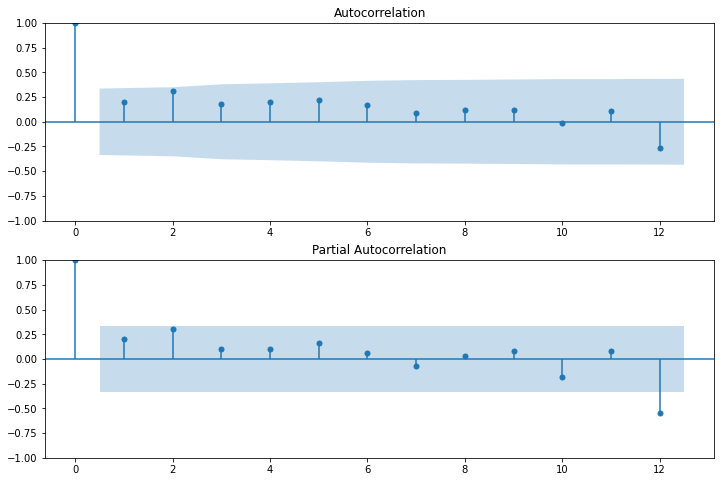

In [184]:
# 残差のチェック
residSARIMA = sarima.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=12, ax=ax2)

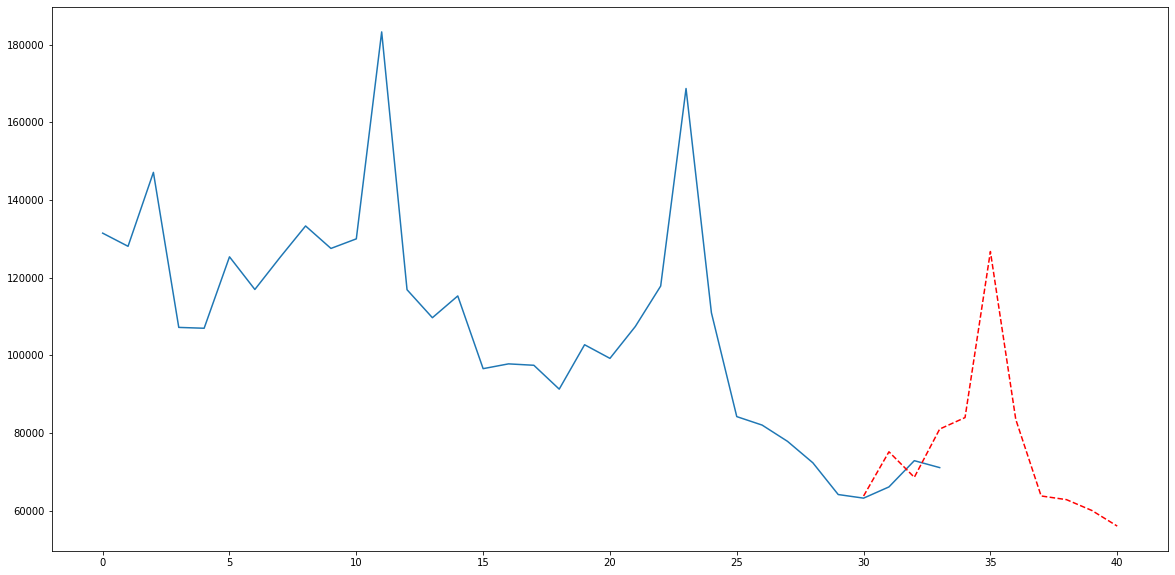

In [185]:
# 予測
bestPred = sarima.predict(30, 40)
# 実データと予測結果の図示
plt.figure(figsize=(20,10))
plt.plot(ts)
plt.plot(bestPred, "r", linestyle='--')

## logデータへのSARIMA適応　（ARIMA→SARIMAパラメータ推定）

In [161]:
ts_log=pd.DataFrame(train_df.groupby(["date_block_num"])["item_cnt_day"].sum())
ts_log['item_cnt_day'] = ts_log['item_cnt_day'].apply(lambda x: np.log(x))

In [162]:
# 差分系列への自動ARMA推定関数の実行
resDiff = sm.tsa.arma_order_select_ic(ts_log_diff, ic='aic')
resDiff

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarn

{'aic':            0          1          2
 0 -19.099869 -19.161242 -19.334524
 1 -18.396937 -21.122410 -19.125863
 2 -18.333804 -16.614721 -18.166936
 3 -16.551794 -14.623973 -15.301070
 4 -14.819506 -17.681363 -14.243521,
 'aic_min_order': (1, 1)}

In [174]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_sp = 1
max_sq = 1
max_sd = 1

pattern = (max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern

8

In [175]:
# 自動SARIMA選択
num = 0
for sp in range(0, max_sp+1):
    for sd in range(0, max_sq+1):
        for sq in range(0, max_sd+1):
            sarima = sm.tsa.SARIMAX(
                ts, order=(1,1,1), 
                seasonal_order=(sp,sd,sq,12), 
                enforce_stationarity = False, 
                enforce_invertibility = False
            ).fit()
            modelSelection.iloc[num]["model"] = f"order=(1,1,1), season=({sp},{sd},{sq}))"
            modelSelection.iloc[num]["aic"] = sarima.aic
            num = num + 1

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04135D+01    |proj g|=  9.82123D-02

At iterate    5    f=  1.04082D+01    |proj g|=  6.76437D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   6.764D-07   1.041D+01
  F =   10.408243313775401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.47687D+00    |proj g|=  1.04127D-02

At iterate   15    f=  6.47671D+00    |proj g|=  4.58190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   2.995D-05   6.477D+00
  F =   6.4767053465361917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32784D+00    |proj g|=  4.23940D-01

At iterate    5    f=  6.14538D+00    |proj g|=  1.30604D-02

At iter

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


In [176]:
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
3,"order=(1,1,1), season=(0,1,1))",144.221511


In [178]:
sarima = sm.tsa.SARIMAX(ts, 
                        order=(1,1,1), seasonal_order=(0,1,1,12), 
                        enforce_stationarity = False, enforce_invertibility = False).fit()
sarima.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13635D+00    |proj g|=  8.67870D-02

At iterate    5    f=  2.10155D+00    |proj g|=  1.09496D-02

At iterate   10    f=  2.10072D+00    |proj g|=  2.54823D-04

At iterate   15    f=  2.10072D+00    |proj g|=  6.82123D-05

At iterate   20    f=  2.10070D+00    |proj g|=  8.53797D-04

At iterate   25    f=  2.10038D+00    |proj g|=  3.64418D-03

At iterate   30    f=  2.04670D+00    |proj g|=  1.74323D-01

At iterate   35    f=  2.00336D+00    |proj g|=  9.67075D-03

At iterate   40    f=  2.00326D+00    |proj g|=  1.06515D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       item_cnt_day   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -68.111
Date:                            Tue, 08 Feb 2022   AIC                            144.222
Time:                                    20:35:48   BIC                            144.005
Sample:                                         0   HQIC                           141.547
                                             - 34                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9506      0.657     -1.447      0.148      -2.238       0.337
ma.L1         -0.4727      0.284     -1.666      0.096      -1.029       0.083
ma.S.L12       0.3070      0.237      1.293      0.196      -0.158       0.772
sigma2      1.638e+07   1.31e-08   1.25e+15      0.000    1.64e+07    1.64e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.52   Prob(JB):                         0.72
Heteroskedasticity (H):               1.49   Skew:                            -0.54
Prob(H) (two-sided):                  0.80   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.39e+31. Standard errors may be unstable.
"""

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


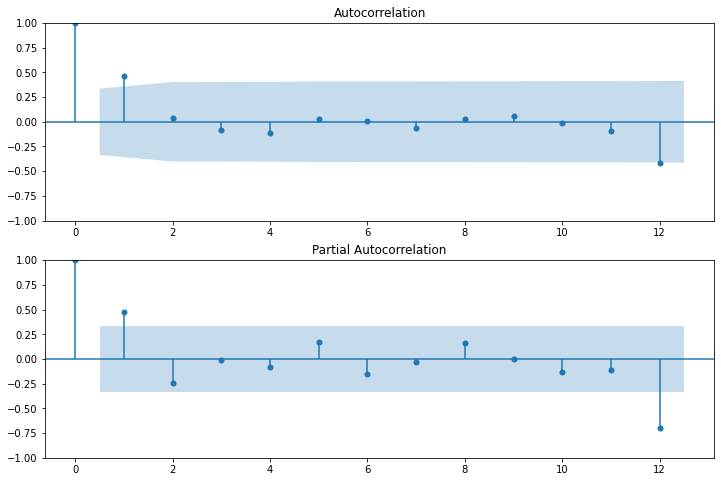

In [179]:
# 残差のチェック
residSARIMA = sarima.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=12, ax=ax2)

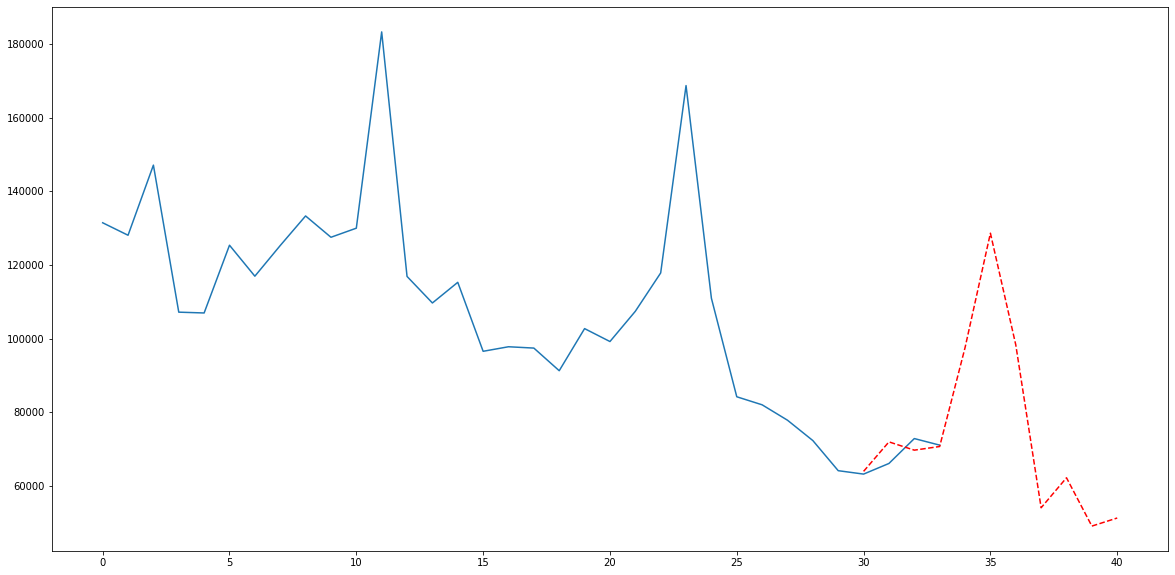

In [180]:
# 予測
bestPred = sarima.predict(30, 40)
# 実データと予測結果の図示
plt.figure(figsize=(20,10))
plt.plot(ts)
plt.plot(bestPred, "r", linestyle='--')

モデルを構築しても残差が残っている・・・。<br>

つまり、、、<br>
まだモデリングできていない成分が残っているということ！！<br>

残っているのは季節性。だが、季節性は主に12月が強く出るだけで他の月は出ないっぽい<br>